# Function Testing Notebook - Joseph

This notebook is meant to test external-facing functions to ensure they are working as expected.

A dedicated test_all_functions.py with unit testing might be better, but this is a good benchmark

In [1]:
import os
import sys
from pathlib import Path
import time
import tempfile
import logging

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import mne
from dask_jobqueue import SLURMCluster
from dask.distributed import Client, LocalCluster
import joblib

In [2]:
# packageroot = Path('../../').resolve()
packageroot = Path('/home/dongjp/source-code/PyEEG').resolve()
print(packageroot)
sys.path.append(str(packageroot))

from pythoneeg import core
from pythoneeg import visualization
# from pythoneeg import constants

print(core.__all__)
# print(visualization.__all__)
# print(dir(constants))

core.set_temp_directory('/scr1/users/dongjp')

/home/dongjp/source-code/PyEEG


/home/dongjp/source-code/PyEEG/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


['DDFBinaryMetadata', 'LongRecordingOrganizer', 'convert_ddfcolbin_to_ddfrowbin', 'convert_ddfrowbin_to_si', 'convert_units_to_multiplier', 'convert_colpath_to_rowpath', 'filepath_to_index', 'is_day', 'set_temp_directory', 'get_temp_directory', 'LongRecordingAnalyzer', 'MountainSortAnalyzer', 'FragmentAnalyzer']


In [3]:
cluster_general = SLURMCluster(
        cores=8,
        memory='20GB',
        walltime='12:00:00',
        interface=None,
        scheduler_options={'interface': 'eth1'},
        job_extra_directives=['--output=/dev/null',
                             '--error=/dev/null']
    )
cluster_general.scale(jobs=10)
display(cluster_general)
cluster_general.wait_for_workers(10)

Dashboard: http://172.16.6.206:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://172.16.6.206:46623,Workers: 0
Dashboard: http://172.16.6.206:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [4]:
# cluster_spike = SLURMCluster(
#         cores=1,
#         memory='10GB',
#         processes=1,
#         walltime='12:00:00',
#         interface=None,
#         scheduler_options={'interface': 'eth1'},
#         job_extra_directives=['--output=/dev/null',
#                              '--error=/dev/null']
#     )
# cluster_spike.scale(10)
# display(cluster_spike)
# cluster_spike.wait_for_workers(10)

In [5]:
# Set up logger with detailed formatting
logging.basicConfig(format='%(asctime)s - %(levelname)s - %(message)s', level=logging.DEBUG, stream=sys.stdout, force=True)
logger = logging.getLogger()

In [6]:
# %%script true
# animal_ids = ['A5', 'A10', 'F22', 'G25']
# animal_ids = ['A5']
animal_ids = ['A10']
# animal_ids = ['F22']
# animal_ids = ['G25']
base_folder = Path('./test-data').resolve()
# base_folder = Path('/mnt/isilon/marsh_single_unit/PythonEEG Data Bins').resolve()
for animal_id in animal_ids:
    ao = visualization.AnimalOrganizer(base_folder, animal_id, mode="concat", assume_from_number=True, truncate=False)
    ao.convert_colbins_to_rowbins(overwrite=False)
    ao.convert_rowbins_to_rec() # paralleization breaks if not enough memory

    # with Client(cluster_window) as client:
    #     client.upload_file(str(packageroot / 'pythoneeg.zip'))
    #     display(client)
    #     print("running war")
    #     war = ao.compute_windowed_analysis(['all'], exclude=['nspike', 'wavetemp'], multiprocess_mode='dask')
    #     war.to_pickle_and_json(Path(f'./test-wars/{animal_id}').resolve())

    # with Client(cluster_spike) as client:
    #     client.upload_file(str(packageroot / 'pythoneeg.zip'))
    #     display(client)
    #     print("running sar")
    #     sar = ao.compute_spike_analysis(multiprocess_mode='dask')

    with Client(LocalCluster()) as client:
        client.upload_file(str(packageroot / 'pythoneeg.zip'))
        display(client)
        print("running sar")
        sar = ao.compute_spike_analysis(multiprocess_mode='dask')

Converting column bins to row bins:   0%|          | 0/1 [00:00<?, ?it/s]

2025-03-20 02:14:09,126 - WARNING - Row-major binary files already exist! Skipping existing files


Converting row bins to recs:   0%|          | 0/1 [00:00<?, ?it/s]

Converting row bins to recs: 100%|██████████| 1/1 [00:00<00:00,  5.55it/s]

2025-03-20 02:14:09,336 - DEBUG - Using selector: EpollSelector



/home/dongjp/source-code/PyEEG/.venv/lib/python3.10/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33749 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:33749/status,
Dashboard: http://127.0.0.1:33749/status,Workers: 4
Total threads: 4,Total memory: 5.78 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38959,Workers: 4
Dashboard: http://127.0.0.1:33749/status,Total threads: 4
Started: Just now,Total memory: 5.78 GiB
Comm: tcp://127.0.0.1:42725,Total threads: 1
Dashboard: http://127.0.0.1:46547/status,Memory: 1.45 GiB
Nanny: tcp://127.0.0.1:40597,


running sar
2025-03-20 02:14:12,285 - DEBUG - Sorting recording info: ChannelSliceRecording: 10 channels - 1000.0Hz - 1 segments - 120,360 samples 
                       120.36s (2.01 minutes) - float32 dtype - 4.59 MiB
2025-03-20 02:14:12,286 - DEBUG - Sorting recording channel names: ['Intan Input (1)/PortC C-009' 'Intan Input (1)/PortC C-010'
 'Intan Input (1)/PortC C-012' 'Intan Input (1)/PortC C-014'
 'Intan Input (1)/PortC C-015' 'Intan Input (1)/PortC C-016'
 'Intan Input (1)/PortC C-017' 'Intan Input (1)/PortC C-019'
 'Intan Input (1)/PortC C-021' 'Intan Input (1)/PortC C-022']


write_binary_recording (no parallelization): 100%|██████████| 3/3 [00:00<00:00, 25.17it/s]


2025-03-20 02:14:17,861 - WARNING - Intan Input (1)/PortC C-009 does not match name aliases. Assuming alias from number in channel name.
2025-03-20 02:14:17,864 - WARNING - Intan Input (1)/PortC C-010 does not match name aliases. Assuming alias from number in channel name.
2025-03-20 02:14:17,865 - WARNING - Intan Input (1)/PortC C-012 does not match name aliases. Assuming alias from number in channel name.
2025-03-20 02:14:17,867 - WARNING - Intan Input (1)/PortC C-014 does not match name aliases. Assuming alias from number in channel name.
2025-03-20 02:14:17,867 - WARNING - Intan Input (1)/PortC C-015 does not match name aliases. Assuming alias from number in channel name.
2025-03-20 02:14:17,867 - WARNING - Intan Input (1)/PortC C-016 does not match name aliases. Assuming alias from number in channel name.
2025-03-20 02:14:17,868 - WARNING - Intan Input (1)/PortC C-017 does not match name aliases. Assuming alias from number in channel name.
2025-03-20 02:14:17,872 - WARNING - Intan

write_binary_recording (no parallelization): 100%|██████████| 3/3 [00:00<00:00, 27.49it/s]


2025-03-20 02:14:17,875 - INFO - Channel names: 	['Intan Input (1)/PortC C-009', 'Intan Input (1)/PortC C-010', 'Intan Input (1)/PortC C-012', 'Intan Input (1)/PortC C-014', 'Intan Input (1)/PortC C-015', 'Intan Input (1)/PortC C-016', 'Intan Input (1)/PortC C-017', 'Intan Input (1)/PortC C-019', 'Intan Input (1)/PortC C-021', 'Intan Input (1)/PortC C-022']
2025-03-20 02:14:17,875 - INFO - Channel abbreviations: 	['LAud', 'LVis', 'LHip', 'LBar', 'LMot', 'RMot', 'RBar', 'RHip', 'RVis', 'RAud']


In [7]:
logger.setLevel(logging.DEBUG)

In [8]:
# for e in sar:
#     e.convert_to_mne(chunk_len=1440)
#     e.save_fif_and_json(Path(f'./test-mnes/{e.animal_day}').resolve())

In [9]:
reconstruct_sas = visualization.SpikeAnalysisResult.load_fif_and_json('./test-mnes/A5 WT Dec-12-2023')
mne_obj = reconstruct_sas.result_mne

Opening raw data file test-mnes/A5 WT Dec-12-2023/A5-WT-A5 WT Dec-12-2023-raw.fif...
    Reading extended channel information
Isotrak not found
    Range : 0 ... 40067758 =      0.000 ... 40067.758 secs
Ready.
2025-03-20 02:14:29,790 - INFO - Channel names: 	['Intan Input (1)/PortB L Aud Ctx', 'Intan Input (1)/PortB L Vis Ctx', 'Intan Input (1)/PortB L Hipp', 'Intan Input (1)/PortB L Barrel', 'Intan Input (1)/PortB L Motor', 'Intan Input (1)/PortB R Motor', 'Intan Input (1)/PortB R Barrel', 'Intan Input (1)/PortB R Hipp', 'Intan Input (1)/PortB R Vis Ctx', 'Intan Input (1)/PortB R Aud Ctx']
2025-03-20 02:14:29,791 - INFO - Channel abbreviations: 	['LAud', 'LVis', 'LHip', 'LBar', 'LMot', 'RMot', 'RBar', 'RHip', 'RVis', 'RAud']


In [10]:
logger.setLevel(logging.WARNING)


Using matplotlib as 2D backend.


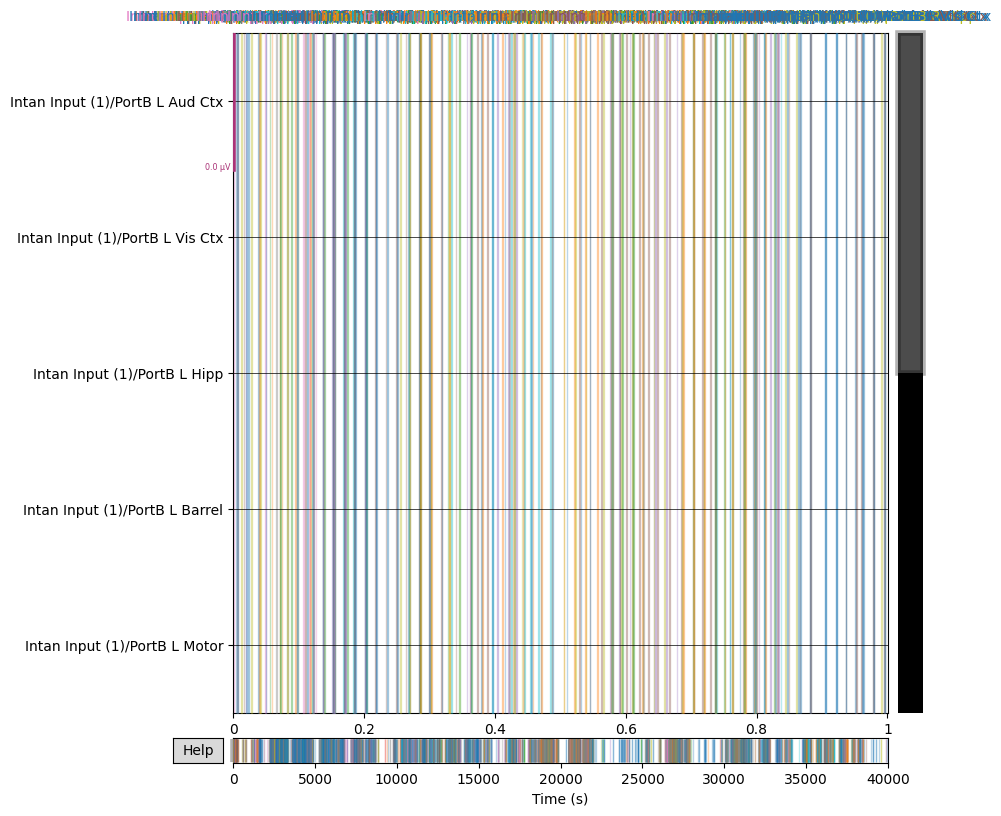

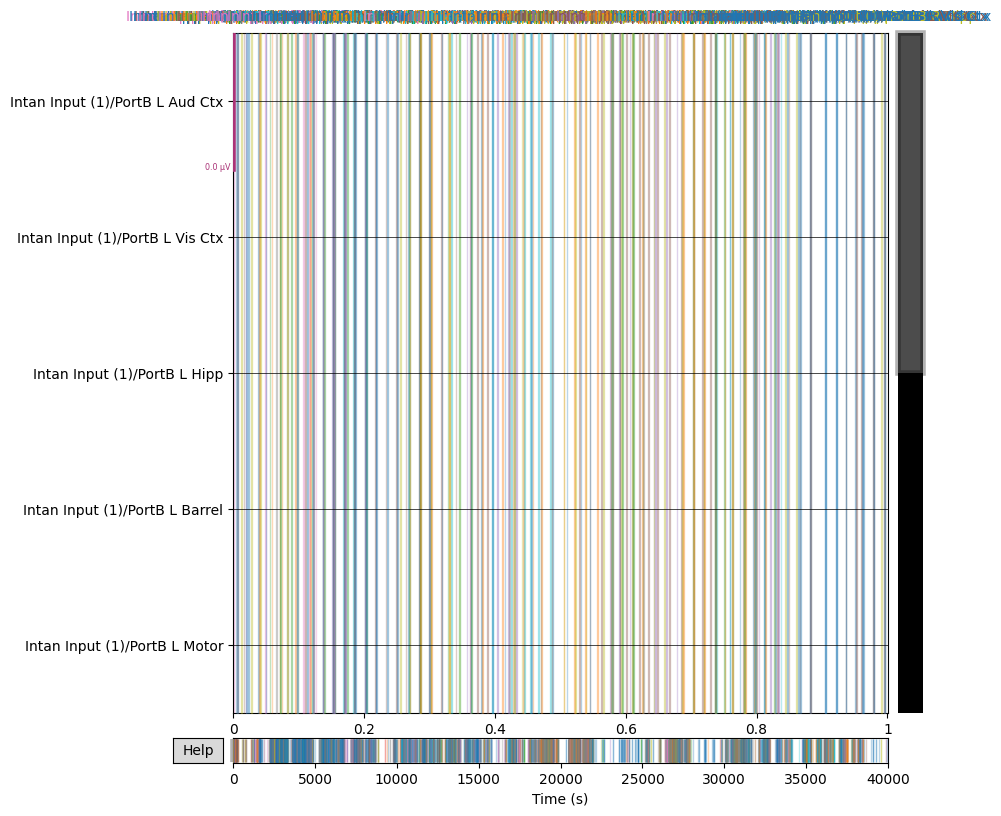

In [12]:
# Quick preview of the raw MNE data
start_time = 0  # Start from beginning
duration = 1   # Show 1 seconds

# Plot first few channels
n_channels = min(5, len(mne_obj.ch_names))  # Show up to 5 channels
mne_obj.copy().crop(60).plot(start=start_time, duration=duration, n_channels=n_channels, 
             scalings='auto', title='Raw data preview')



In [ ]:
events, event_id = mne.events_from_annotations(raw=mne_obj)
fig = mne.viz.plot_events(events, sfreq=mne_obj.info['sfreq'], first_samp=mne_obj.first_samp, event_id=event_id)

In [11]:
def random_subsample_epochs(epochs: mne.Epochs, max_epochs=1000):
    if len(epochs) > max_epochs:
        # Get random indices for subsampling
        indices = np.random.choice(len(epochs), size=max_epochs, replace=False)
        epochs = epochs[indices]
    return epochs

In [21]:
# quick hack to look at peri-spike EEG

def analyze_peri_spike_tfr(mne_obj: mne.io.Raw, tmin=-10, tmax=5, tcrop=(-3, 3), baseline=(None, -5), l_freq=1, h_freq=50):
    """
    Analyze time-frequency representation around spikes from an MNE object.
    
    Parameters:
    -----------
    mne_obj : mne.io.Raw
        The MNE object containing the data and spike annotations
    tmin : float
        Start time relative to spike (in seconds)
    tmax : float
        End time relative to spike (in seconds)
    tcrop : tuple
        Time range to crop the data (in seconds)
    baseline : tuple
        Time range to compute baseline (in seconds)
    l_freq : float
        Lower frequency bound for filtering
    h_freq : float
        Upper frequency bound for filtering
    """
    raw = mne_obj.copy()
    
    # with joblib.parallel_backend('dask', scheduler_host=cluster_general.scheduler_address):
    # raw.filter(l_freq=l_freq, h_freq=h_freq)

    events, event_dict = mne.events_from_annotations(raw=raw)
    logging.debug(f"Events: {events}")
    logging.debug(f"Event dict: {event_dict}")

    # Process each spike type separately
    for channel_name in event_dict.keys():
        logging.debug(f"Processing channel: {channel_name}")
        
        # Create spike-centered epochs
        epochs = mne.Epochs(
            raw,
            tmin=tmin,
            tmax=tmax,
            baseline=baseline,
            event_repeated='drop',
            # preload=True,
            event_id=channel_name,
        )
        epochs.drop_bad()
        epochs = random_subsample_epochs(epochs).load_data()
        epochs.crop(tmin=tcrop[0], tmax=tcrop[1])
        # with joblib.parallel_backend('dask', scheduler_host=cluster_general.scheduler_address):
        epochs.filter(l_freq=l_freq, h_freq=h_freq)
        
        # Plot the epochs
        epochs.plot_image([channel_name])

        
        # Compute time-frequency representation
        tfr_params = dict(
            freqs=np.arange(l_freq, h_freq, 1),
            n_cycles=np.arange(l_freq, h_freq, 1) * 2,
            method='multitaper',
            use_fft=True,
            average=True
        )
        
        logging.info(f"Computing TFR: {channel_name}")
        with joblib.parallel_config('dask', scheduler_host=cluster_general.scheduler_address):
            tfr_spike = epochs.compute_tfr(**tfr_params)
        # tfr_baseline = epochs_baseline.compute_tfr(**tfr_params)
        
        # Plot the results
        # plot_tfr_difference(tfr_spike, tfr_baseline)
        tfr_spike.plot()

        break

# def plot_tfr_difference(tfr_spike, tfr_baseline):
#     """Plot the ratio between spike and baseline TFR."""
#     pow_baseline = np.mean(tfr_baseline.get_data(), axis=(0, 2))
#     pow_baseline = pow_baseline[:, np.newaxis]
#     pow_spike, plot_t, plot_f = tfr_spike.get_data(return_times=True, return_freqs=True)
#     pow_spike = np.mean(pow_spike, axis=0)
#     pow_ratio = pow_spike - pow_baseline
    
#     fig, ax = plt.subplots(1, 1, figsize=(7, 4))
#     im = ax.imshow(pow_ratio, aspect='auto',
#                    extent=[plot_t[0], plot_t[-1], plot_f[0], plot_f[-1]],
#                    origin='lower',
#                    cmap=plt.cm.RdBu_r,
#                    norm=colors.CenteredNorm())
#                 #    norm=colors.TwoSlopeNorm(vmin=0.5, vcenter=1, vmax=10))
    
#     ax.set_xlabel('Time (s)')
#     ax.set_ylabel('Frequency (Hz)')
#     ax.axvline(0, color='black', linestyle='--')
#     plt.colorbar(im, ax=ax, label='Power Ratio (spike/baseline)')
#     plt.show()


In [22]:
logger.setLevel(logging.DEBUG)

Used Annotations descriptions: [np.str_('Intan Input (1)/PortB L Aud Ctx'), np.str_('Intan Input (1)/PortB L Barrel'), np.str_('Intan Input (1)/PortB L Hipp'), np.str_('Intan Input (1)/PortB L Motor'), np.str_('Intan Input (1)/PortB L Vis Ctx'), np.str_('Intan Input (1)/PortB R Aud Ctx'), np.str_('Intan Input (1)/PortB R Barrel'), np.str_('Intan Input (1)/PortB R Hipp'), np.str_('Intan Input (1)/PortB R Motor'), np.str_('Intan Input (1)/PortB R Vis Ctx')]
2025-03-20 02:04:47,414 - DEBUG - Events: [[     121        0        5]
 [     123        0        4]
 [     140        0        5]
 ...
 [39927617        0        6]
 [39959934        0        7]
 [39975664        0       10]]
2025-03-20 02:04:47,415 - DEBUG - Event dict: {np.str_('Intan Input (1)/PortB L Aud Ctx'): 1, np.str_('Intan Input (1)/PortB L Barrel'): 2, np.str_('Intan Input (1)/PortB L Hipp'): 3, np.str_('Intan Input (1)/PortB L Motor'): 4, np.str_('Intan Input (1)/PortB L Vis Ctx'): 5, np.str_('Intan Input (1)/PortB R Aud

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    1.5s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    1.8s
[Parallel(n_jobs=1)]: Done 3041 tasks      | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done 3527 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    2.7s
[Parallel(n_jobs=1)]: Done 4607 tasks      | elapsed:    3.0s
[Parallel(n_job

Not setting metadata
1000 matching events found
No baseline correction applied
0 projection items activated
2025-03-20 02:05:48,783 - DEBUG - colorbar update normal <matplotlib.colors.Normalize object at 0x7f7b6c59fa00> <matplotlib.colors.Normalize object at 0x7f7b6c59fa00>
2025-03-20 02:05:48,787 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7f7b4cbe9600>
2025-03-20 02:05:48,789 - DEBUG - colorbar update normal <matplotlib.colors.Normalize object at 0x7f7b6c59fa00> <matplotlib.colors.Normalize object at 0x7f7b6c59fa00>
2025-03-20 02:05:48,790 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7f7b4cbe9600>
2025-03-20 02:05:48,794 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7f7b4cbe8f40>
2025-03-20 02:05:48,857 - DEBUG - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
2025-03-20 02:05:48,862 - DEBUG - findfont: score(FontEntry(fname='/home/dongjp/source-code/PyEEG/.venv/lib/python3.10/site-p

/tmp/ipykernel_355764/1442056519.py:54: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  epochs.plot_image([channel_name])


2025-03-20 02:05:48,979 - DEBUG - findfont: score(FontEntry(fname='/usr/share/fonts/dejavu-serif-fonts/DejaVuSerif-Italic.ttf', name='DejaVu Serif', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
2025-03-20 02:05:48,980 - DEBUG - findfont: score(FontEntry(fname='/usr/share/fonts/dejavu-sans-fonts/DejaVuSansCondensed-Oblique.ttf', name='DejaVu Sans', style='oblique', variant='normal', weight=400, stretch='condensed', size='scalable')) = 1.25
2025-03-20 02:05:48,984 - DEBUG - findfont: score(FontEntry(fname='/usr/share/fonts/dejavu-sans-fonts/DejaVuSans-Oblique.ttf', name='DejaVu Sans', style='oblique', variant='normal', weight=400, stretch='normal', size='scalable')) = 1.05
2025-03-20 02:05:48,985 - DEBUG - findfont: score(FontEntry(fname='/usr/share/fonts/liberation-mono/LiberationMono-Italic.ttf', name='Liberation Mono', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
2025-03-20 02:05:48,986 - DEBUG -

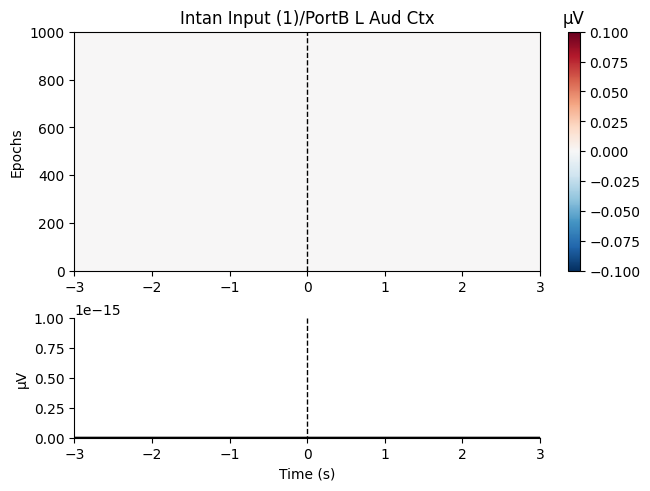

2025-03-20 02:05:50,706 - INFO - Computing TFR: Intan Input (1)/PortB L Aud Ctx
2025-03-20 02:05:50,709 - DEBUG - Using selector: EpollSelector


[Parallel(n_jobs=-1)]: Using backend DaskDistributedBackend with 80 concurrent workers.


KeyboardInterrupt: 

In [23]:
# display(mne_obj)
analyze_peri_spike_tfr(mne_obj)